In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(2)
torch.manual_seed(0)

# Load the Datasets

In [58]:
X_train = np.load("./numpy_ds/x_train.npy")
X_val = np.load("./numpy_ds/x_val.npy")
X_test = np.load("./numpy_ds/x_test.npy")

y_train = np.load("./numpy_ds/y_train.npy")
y_val = np.load("./numpy_ds/y_val.npy")
y_test = np.load("./numpy_ds/y_test.npy")

# Designing the Model

In [112]:
class FFSpeechMode(nn.Module):
    def __init__(self):
        super(FFSpeechMode, self).__init__()
        self.activationLayer = nn.PReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(299*13, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 8)
        self.fc5 = nn.Linear(8,3)
    
    def forward(self, x):
        x = self.activationLayer(self.fc1(x))
        x = self.dropout(x)
        x = self.activationLayer(self.fc2(x))
        x = self.activationLayer(self.fc3(x))
        x = self.dropout(x)
        x = self.activationLayer(self.fc4(x))
        x = self.fc5(x)

        return x

In [114]:
random.seed(0)

def train_ffsm(model, x_tr, y_tr, x_v, y_v, criterion, optimizer, epoch_range, batch_size):
    losses = []
    v_losses = []
   
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, x_tr.shape[0]), batch_size)
        x = np.zeros((batch_size, 299*13))
        y = np.zeros((batch_size, 3))
        for i, feats in enumerate(selected):
            x[i, :] = x_tr[feats, :, :].flatten()
            y[i, :] = y_tr[feats, :]
        x = torch.from_numpy(x).float().cuda()
        y = torch.from_numpy(y).long().cuda()
        #---------FORWARD------------#
        out = model.forward(x)
        out = torch.tensor(out).float().cuda()
        loss = criterion(out, torch.max(y,1)[1])
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, x_v.shape[0]), 8)
        xv = np.zeros((8, 299*13))
        yv = np.zeros((8, 3))
        for i, feats in enumerate(v):
            xv[i, :] = x_v[feats, :, :].flatten()
            yv[i, :] = y_v[feats, :]
        xv = torch.from_numpy(xv).float().cuda()
        yv = torch.from_numpy(yv).long().cuda()
        v_out = model.forward(xv)
        v_out = torch.tensor(v_out).float().cuda()
        vloss = criterion(v_out, torch.max(yv, 1)[1])
        
        losses.append(loss.data[0])
        v_losses.append(vloss.data[0])
        if num_epoch%100 == 0:
            print('epoch [{}/{}], loss:{:.8f}, val:{:.8f}'.format(num_epoch, epoch_range, 
                                                              loss.data[0], vloss.data[0]))
    return losses, v_losses

In [113]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

In [115]:
mdl1 = FFSpeechMode().cuda()
mdl1.apply(init_weights)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(
    mdl1.parameters(), lr=learning_rate, weight_decay=0.001)

epoch_range = 25000
batch_size = 48
losses_12, vlosses_12 = train_ffsm(mdl1, X_train, y_train, X_val, y_val, 
                                 criterion, optimizer, epoch_range, batch_size)

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [0/25000], loss:29.55150414, val:34.18191910
epoch [100/25000], loss:1.38785946, val:5.10079432
epoch [200/25000], loss:0.40207973, val:1.07155502
epoch [300/25000], loss:0.39760569, val:0.84520113
epoch [400/25000], loss:0.04909322, val:0.38022402
epoch [500/25000], loss:0.33029607, val:5.52976131
epoch [600/25000], loss:0.03298470, val:0.88101625
epoch [700/25000], loss:0.00269370, val:0.00640899
epoch [800/25000], loss:0.05806816, val:5.36718893
epoch [900/25000], loss:0.01798327, val:1.17219138
epoch [1000/25000], loss:0.00287773, val:0.00023210
epoch [1100/25000], loss:0.00024436, val:0.08067268
epoch [1200/25000], loss:0.00021682, val:0.02009687
epoch [1300/25000], loss:0.00000463, val:3.63756585
epoch [1400/25000], loss:0.00051098, val:1.04637647
epoch [1500/25000], loss:0.09027765, val:2.86617637
epoch [1600/25000], loss:0.10411101, val:0.50759649
epoch [1700/25000], loss:0.00054122, val:1.07935464
epoch [1800/25000], loss:0.01241662, val:2.93995953
epoch [1900/25000], lo

epoch [15700/25000], loss:0.00102341, val:0.97468281
epoch [15800/25000], loss:0.00155891, val:0.00060189
epoch [15900/25000], loss:0.00015837, val:0.14737462
epoch [16000/25000], loss:0.04064594, val:0.97267127
epoch [16100/25000], loss:0.00639031, val:0.04380971
epoch [16200/25000], loss:0.00069967, val:1.45131612
epoch [16300/25000], loss:0.00056875, val:1.61372077
epoch [16400/25000], loss:0.04659900, val:0.83518195
epoch [16500/25000], loss:0.00428853, val:0.03288198
epoch [16600/25000], loss:0.03223674, val:0.42166361
epoch [16700/25000], loss:0.00146108, val:0.84491771
epoch [16800/25000], loss:0.00040683, val:0.00218326
epoch [16900/25000], loss:0.00006329, val:0.00005955
epoch [17000/25000], loss:0.00004688, val:0.24991110
epoch [17100/25000], loss:0.00061661, val:2.43118000
epoch [17200/25000], loss:0.00571731, val:0.46156073
epoch [17300/25000], loss:0.00103061, val:0.40959054
epoch [17400/25000], loss:0.00709473, val:0.26357973
epoch [17500/25000], loss:0.00046560, val:0.10

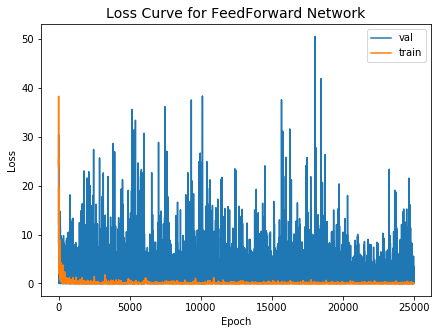

In [110]:
fig = plt.figure(figsize=(7, 5))
plt.title("Loss Curve for FeedForward Network", fontsize=14)
plt.plot(vlosses_12, label="val")
plt.plot(losses_12, label="train")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#fig.savefig("./images/ffsm_performance.pdf", bbox_inches='tight')

# Testing on the Test Set

In [116]:
# Indicated by maximum energy

total = y_test.shape[0]
correct = 0

for i in range(X_test.shape[0]):
    data = X_test[i, :, :].flatten()
    #print(data)
    data = torch.from_numpy(data).float().cuda()
    true_out = y_test[i, :]
    mdl_out = mdl1.forward(data)
    out = (mdl_out.data).cpu().numpy()
    if np.argmax(out) == np.argmax(true_out):
        correct += 1
print("Accuracy = ", correct*100/total)

Accuracy =  84.02777777777777
